In [1]:
%matplotlib inline


# Release Highlights for scikit-learn 0.24

.. currentmodule:: sklearn

We are pleased to announce the release of scikit-learn 0.24! Many bug fixes
and improvements were added, as well as some new key features. We detail
below a few of the major features of this release. **For an exhaustive list of
all the changes**, please refer to the `release notes <changes_0_24>`.

To install the latest version (with pip)::

    pip install --upgrade scikit-learn

or with conda::

    conda install -c conda-forge scikit-learn


## Successive Halving estimators for tuning hyper-parameters
Successive Halving, a state of the art method, is now available to
explore the space of the parameters and identify their best combination.
:class:`~sklearn.model_selection.HalvingGridSearchCV` and
:class:`~sklearn.model_selection.HalvingRandomSearchCV` can be
used as drop-in replacement for
:class:`~sklearn.model_selection.GridSearchCV` and
:class:`~sklearn.model_selection.RandomizedSearchCV`.
Successive Halving is an iterative selection process illustrated in the
figure below. The first iteration is run with a small amount of resources,
where the resource typically corresponds to the number of training samples,
but can also be an arbitrary integer parameter such as `n_estimators` in a
random forest. Only a subset of the parameter candidates are selected for the
next iteration, which will be run with an increasing amount of allocated
resources. Only a subset of candidates will last until the end of the
iteration process, and the best parameter candidate is the one that has the
highest score on the last iteration.

Read more in the `User Guide <successive_halving_user_guide>` (note:
the Successive Halving estimators are still :term:`experimental
<experimental>`).

.. figure:: ../model_selection/images/sphx_glr_plot_successive_halving_iterations_001.png
  :target: ../model_selection/plot_successive_halving_iterations.html
  :align: center



In [2]:
import numpy as np
from scipy.stats import randint
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

rng = np.random.RandomState(0)

X, y = make_classification(n_samples=700, random_state=rng)

clf = RandomForestClassifier(n_estimators=10, random_state=rng)

param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 11),
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rsh = HalvingRandomSearchCV(estimator=clf, param_distributions=param_dist,
                            factor=2, random_state=rng)
rsh.fit(X, y)
rsh.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 10,
 'min_samples_split': 10}

## Native support for categorical features in HistGradientBoosting estimators
:class:`~sklearn.ensemble.HistGradientBoostingClassifier` and
:class:`~sklearn.ensemble.HistGradientBoostingRegressor` now have native
support for categorical features: they can consider splits on non-ordered,
categorical data. Read more in the `User Guide
<categorical_support_gbdt>`.

.. figure:: ../ensemble/images/sphx_glr_plot_gradient_boosting_categorical_001.png
  :target: ../ensemble/plot_gradient_boosting_categorical.html
  :align: center

The plot shows that the new native support for categorical features leads to
fitting times that are comparable to models where the categories are treated
as ordered quantities, i.e. simply ordinal-encoded. Native support is also
more expressive than both one-hot encoding and ordinal encoding. However, to
use the new `categorical_features` parameter, it is still required to
preprocess the data within a pipeline as demonstrated in this `example
<sphx_glr_auto_examples_ensemble_plot_gradient_boosting_categorical.py>`.



## Improved performances of HistGradientBoosting estimators
The memory footprint of :class:`ensemble.HistGradientBoostingRegressor` and
:class:`ensemble.HistGradientBoostingClassifier` has been significantly
improved during calls to `fit`. In addition, histogram initialization is now
done in parallel which results in slight speed improvements.
See more in the `Benchmark page
<https://scikit-learn.org/scikit-learn-benchmarks/>`_.



## New self-training meta-estimator
A new self-training implementation, based on `Yarowski's algorithm
<https://doi.org/10.3115/981658.981684>`_ can now be used with any
classifier that implements :term:`predict_proba`. The sub-classifier
will behave as a
semi-supervised classifier, allowing it to learn from unlabeled data.
Read more in the `User guide <self_training>`.



In [3]:
import numpy as np
from sklearn import datasets
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

rng = np.random.RandomState(42)
iris = datasets.load_iris()
random_unlabeled_points = rng.rand(iris.target.shape[0]) < 0.3
iris.target[random_unlabeled_points] = -1
svc = SVC(probability=True, gamma="auto")
self_training_model = SelfTrainingClassifier(svc)
self_training_model.fit(iris.data, iris.target)

SelfTrainingClassifier(base_estimator=SVC(gamma='auto', probability=True))

## New SequentialFeatureSelector transformer
A new iterative transformer to select features is available:
:class:`~sklearn.feature_selection.SequentialFeatureSelector`.
Sequential Feature Selection can add features one at a time (forward
selection) or remove features from the list of the available features
(backward selection), based on a cross-validated score maximization.
See the `User Guide <sequential_feature_selection>`.



In [4]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True, as_frame=True)
feature_names = X.columns
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=2)
sfs.fit(X, y)
print("Features selected by forward sequential selection: "
      f"{feature_names[sfs.get_support()].tolist()}")

Features selected by forward sequential selection: ['petal length (cm)', 'petal width (cm)']


## New PolynomialCountSketch kernel approximation function
The new :class:`~sklearn.kernel_approximation.PolynomialCountSketch`
approximates a polynomial expansion of a feature space when used with linear
models, but uses much less memory than
:class:`~sklearn.preprocessing.PolynomialFeatures`.



In [5]:
from sklearn.datasets import fetch_covtype
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.linear_model import LogisticRegression

X, y = fetch_covtype(return_X_y=True)
pipe = make_pipeline(MinMaxScaler(),
                     PolynomialCountSketch(degree=2, n_components=300),
                     LogisticRegression(max_iter=1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=5000,
                                                    test_size=10000,
                                                    random_state=42)
pipe.fit(X_train, y_train).score(X_test, y_test)

0.7345

For comparison, here is the score of a linear baseline for the same data:



In [6]:
linear_baseline = make_pipeline(MinMaxScaler(),
                                LogisticRegression(max_iter=1000))
linear_baseline.fit(X_train, y_train).score(X_test, y_test)

0.7137

## Individual Conditional Expectation plots
A new kind of partial dependence plot is available: the Individual
Conditional Expectation (ICE) plot. ICE plots visualize the dependence of the
prediction on a feature for each sample separately, with one line per sample.
See the `User Guide <individual_conditional>`



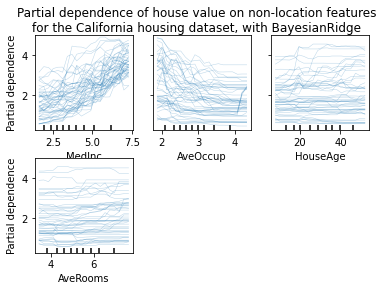

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.inspection import plot_partial_dependence

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
est = RandomForestRegressor(n_estimators=10)
est.fit(X, y)
display = plot_partial_dependence(
       est, X, features, kind="individual", subsample=50,
       n_jobs=3, grid_resolution=20, random_state=0
)
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with BayesianRidge'
)
display.figure_.subplots_adjust(hspace=0.3)

## New Poisson splitting criterion for DecisionTreeRegressor
The integration of Poisson regression estimation continues from version 0.23.
:class:`~sklearn.tree.DecisionTreeRegressor` now supports a new `'poisson'`
splitting criterion. Setting `criterion="poisson"` might be a good choice
if your target is a count or a frequency.



In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import numpy as np

n_samples, n_features = 1000, 20
rng = np.random.RandomState(0)
X = rng.randn(n_samples, n_features)
# positive integer target correlated with X[:, 5] with many zeros:
y = rng.poisson(lam=np.exp(X[:, 5]) / 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)
regressor = DecisionTreeRegressor(criterion='poisson', random_state=0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='poisson', random_state=0)

## New documentation improvements

New examples and documentation pages have been added, in a continuous effort
to improve the understanding of machine learning practices:

- a new section about `common pitfalls and recommended
  practices <common_pitfalls>`,
- an example illustrating how to `statistically compare the performance of
  models <sphx_glr_auto_examples_model_selection_plot_grid_search_stats.py>`
  evaluated using :class:`~sklearn.model_selection.GridSearchCV`,
- an example on how to `interpret coefficients of linear models
  <sphx_glr_auto_examples_inspection_plot_linear_model_coefficient_interpretation.py>`,
- an `example
  <sphx_glr_auto_examples_cross_decomposition_plot_pcr_vs_pls.py>`
  comparing Principal Component Regression and Partial Least Squares.

